# Global imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores

# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions

seed = 12345

# Dataset: 4 folded diffused circles

In [3]:
from sklearn.datasets import make_circles
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
np.random.seed(seed=7)

n_samples = 100
radii = [2.0, 5.0]
factors = [0.5, 0.7]

X = []
y = []

for i, d in enumerate(radii):
    _X, _y = make_circles(n_samples=int(n_samples*d), noise=0.1, random_state=81, factor=factors[i])
    for i, _ in enumerate(_y):
        X.append(_X[i,:]*d)
        y.append(_y[i])
    
X = np.array(X)
y = np.array(y)
y = 2*y-1 # rescale to [-1,1]

# plt.figure(figsize=(5,5))
# plt.scatter(X[:, 0], X[:, 1], s=50, c=y, marker='o', cmap=plt.cm.Paired)
# plt.show()

xmin = -1; xmax = 1
X = MinMaxScaler(feature_range=(xmin, xmax), copy=False).fit_transform(X)
# X = MaxAbsScaler().fit_transform(X)

# shuffle dataset elements
def unison_shuffled(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, y = unison_shuffled(X, y)
print(X.shape)

(700, 2)


Training target statistics: Counter({-1: 10, 1: 10})
Testing target statistics: Counter({-1: 10, 1: 10})


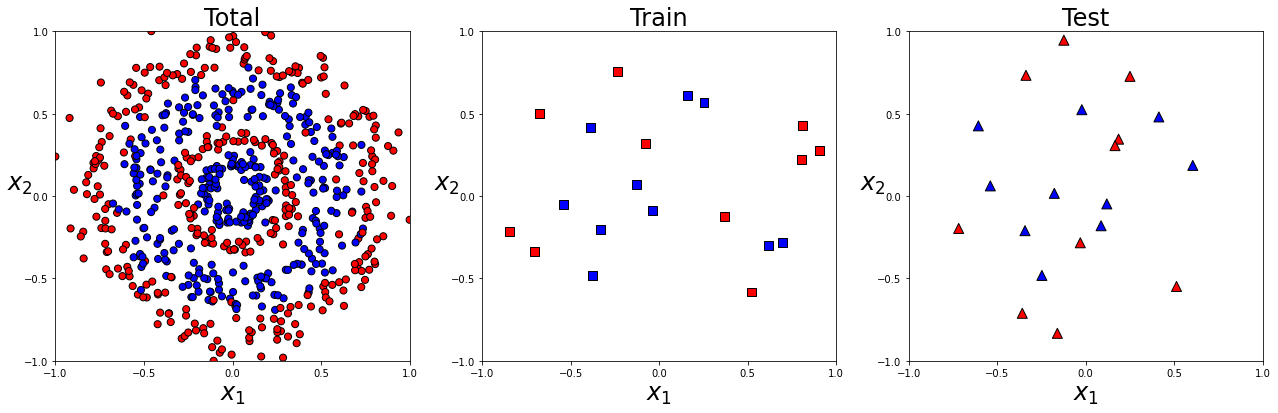

In [4]:
from sklearn.model_selection import train_test_split

train_size = 20
test_size = 20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=42,
)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=24)
plot_dataset(X, y, ax1, axes)

ax2.set_title("Train", fontsize=24)
plot_dataset(X_train, y_train, ax2, axes, marker='s', size=80)

ax3.set_title("Test", fontsize=24)
plot_dataset(X_test, y_test, ax3, axes, marker='^', size=100)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

# RBF SVM

## Training

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 2, 4, 6, 8, 10, 100, 1000, 2000, 3000],
}

clf = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
)
clf.fit(X_train, y_train)

print('Best grid search parameters:', clf.best_params_)
print('Best training score:', clf.best_score_)

Best grid search parameters: {'C': 1000, 'gamma': 0.1}
Best training score: 0.7


## Predictions/Decision boundaries plot

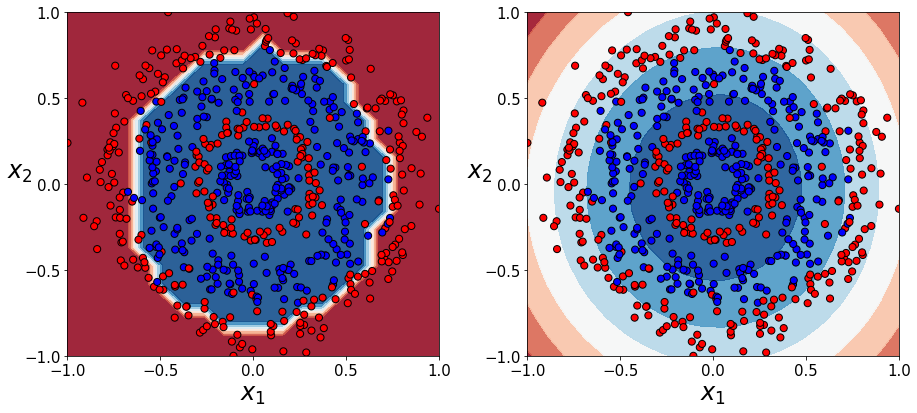

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(clf.best_estimator_, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(clf.best_estimator_, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()

## Model cross-validation

In [7]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 2, 4, 6, 8, 10, 100, 1000],
}

# train_size = 10
# test_size = 10
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    
    print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        print(f"Train/Test CV Subset {i}")

        clf = GridSearchCV(
            estimator=SVC(kernel='rbf'),
            param_grid=param_grid,
            scoring='balanced_accuracy',
            n_jobs=1,
            refit=True,
            cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=_seed),
        )

        clf.fit(X[train,:], y[train])

        train_scores = get_scores(clf.best_estimator_, X[train,:], y[train])
        test_scores = get_scores(clf.best_estimator_, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_clf = clf.best_estimator_

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')

rnd seed 20962
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 11749
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 64797
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 2177
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 19876
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5

==== Cross-Validation Scores ====

Best train score:  0.75

Train set:
   Balanced accuracy:  0.86 +- 0.09
                  F1:  0.85 +- 0.09
             ROC_AUC:  0.89 +- 0.10
                 MCC:  0.72 +- 0.19

Test set:
   Balanced accuracy:  0.64 +- 0.07
                  F1:  0.63 +- 0.08
             ROC_AUC:  0.67 +- 0.11
                

In [8]:
scores_ = get_scores(best_clf, X, y)
print_scores(scores_, title='Entire set:')


Entire set:
   Balanced accuracy:  0.71
                  F1:  0.70
             ROC_AUC:  0.73
                 MCC:  0.43


## Best CV Predictions/Decision boundaries plot

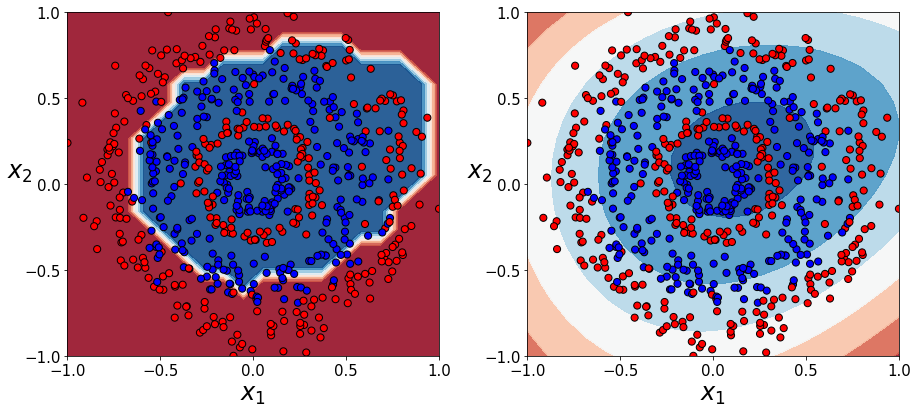

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(best_clf, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(best_clf, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()

# QKE SVM

## Setting up the quantum feature map 

In [5]:
from qksvm.QuantumFeatureMap import QuantumFeatureMap

fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=3,
    gates=['RX', 'cz'], entanglement='linear',
    repeat=True,
)
print(fm.draw(plot_barriers=False, fold=120))

     ┌────────────┐     ┌────────────┐     ┌────────────┐     
q_0: ┤ Rx(x[0]*α) ├──■──┤ Rx(x[0]*α) ├──■──┤ Rx(x[0]*α) ├──■──
     ├────────────┤  │  ├────────────┤  │  ├────────────┤  │  
q_1: ┤ Rx(x[1]*α) ├──■──┤ Rx(x[1]*α) ├──■──┤ Rx(x[1]*α) ├──■──
     └────────────┘     └────────────┘     └────────────┘     


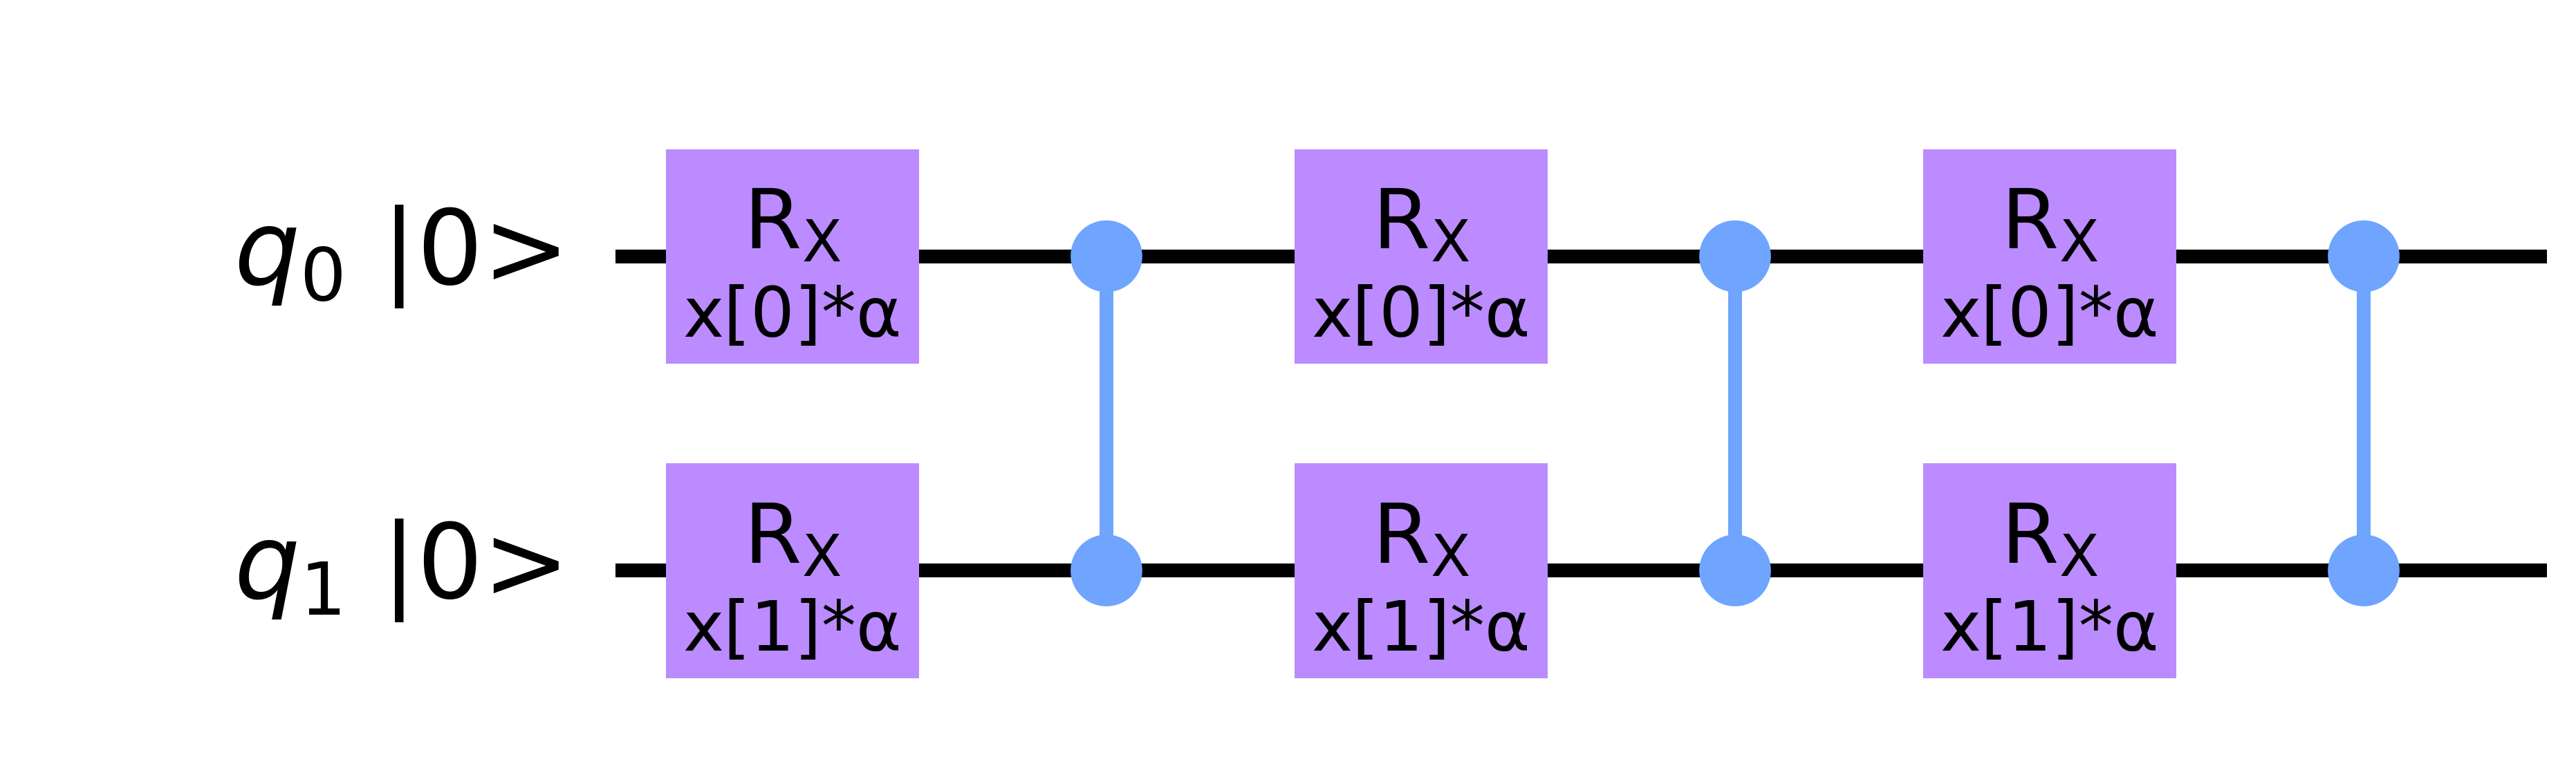

In [6]:
large_font = {
    "fontsize": 12,
    "subfontsize": 10,  
}
fm.draw(plot_barriers=False, fold=180, output='mpl', scale=10, style=large_font, initial_state=True)


Train scores:
   Balanced accuracy:  0.90
                  F1:  0.90
             ROC_AUC:  0.98
                 MCC:  0.80

Test scores:
   Balanced accuracy:  0.80
                  F1:  0.80
             ROC_AUC:  0.82
                 MCC:  0.61


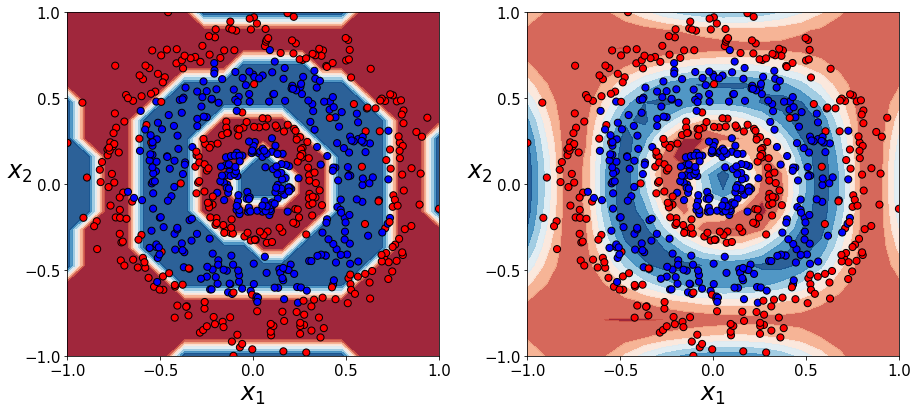

In [23]:
from qksvm.QKSVM import QSVC

qsvc = QSVC(fm, alpha=3.9, C=1.0, random_state=seed)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)
plot_decisions(qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)
plt.tight_layout()
plt.show()

## Model cross-validation

In [19]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

# train_size = 10
# test_size = 10
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    
    print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        print(f"Train/Test CV Subset {i}")
        
        qsvc.fit(X_train, y_train)

        train_scores = get_scores(qsvc, X[train,:], y[train])
        test_scores = get_scores(qsvc, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')

rnd seed 20962
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 11749
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 64797
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 2177
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5
rnd seed 19876
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5

==== Cross-Validation Scores ====

Best train score:  0.95

Train set:
   Balanced accuracy:  0.80 +- 0.08
                  F1:  0.80 +- 0.08
             ROC_AUC:  0.88 +- 0.08
                 MCC:  0.62 +- 0.16

Test set:
   Balanced accuracy:  0.79 +- 0.08
                  F1:  0.78 +- 0.09
             ROC_AUC:  0.86 +- 0.08
                

In [20]:
scores_ = get_scores(best_qsvc, X, y)
print_scores(scores_, title='Entire set:')


Entire set:
   Balanced accuracy:  0.81
                  F1:  0.81
             ROC_AUC:  0.89
                 MCC:  0.61


## Best CV Predictions/Decision boundaries plot

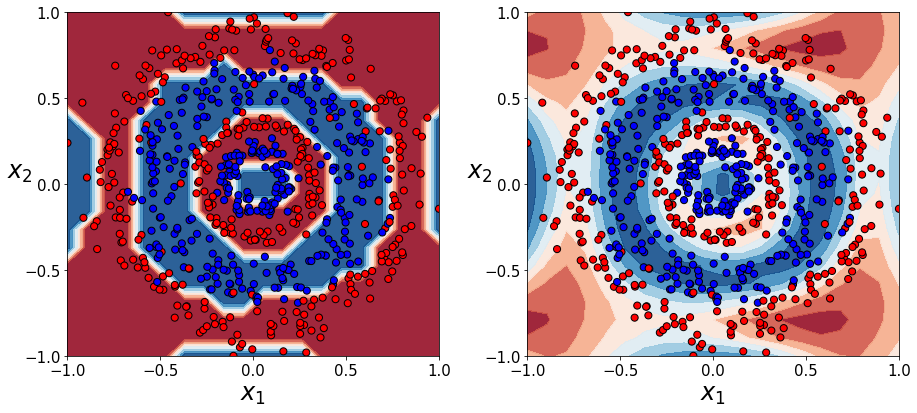

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(best_qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(best_qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()